In [1]:
import os
import glob
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql.functions import col, last, first, coalesce

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


In [4]:
# Build a .py script that takes a snapshot date, trains a model and outputs artefact into storage.

## set up pyspark session

In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/28 01:50:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## set up config

In [3]:
# set up config
model_train_date_str = "2024-09-01"
train_test_period_months = 12
oot_period_months = 2
train_test_ratio = 0.8

config = {}
config["model_train_date_str"] = model_train_date_str
config["train_test_period_months"] = train_test_period_months
config["oot_period_months"] =  oot_period_months
config["model_train_date"] =  datetime.strptime(model_train_date_str, "%Y-%m-%d")
config["oot_end_date"] =  config['model_train_date'] - timedelta(days = 1)
config["oot_start_date"] =  config['model_train_date'] - relativedelta(months = oot_period_months)
config["train_test_end_date"] =  config["oot_start_date"] - timedelta(days = 1)
config["train_test_start_date"] =  config["oot_start_date"] - relativedelta(months = train_test_period_months)
config["train_test_ratio"] = train_test_ratio 


pprint.pprint(config)

{'model_train_date': datetime.datetime(2024, 9, 1, 0, 0),
 'model_train_date_str': '2024-09-01',
 'oot_end_date': datetime.datetime(2024, 8, 31, 0, 0),
 'oot_period_months': 2,
 'oot_start_date': datetime.datetime(2024, 7, 1, 0, 0),
 'train_test_end_date': datetime.datetime(2024, 6, 30, 0, 0),
 'train_test_period_months': 12,
 'train_test_ratio': 0.8,
 'train_test_start_date': datetime.datetime(2023, 7, 1, 0, 0)}


## get label store

In [4]:
# connect to label store
folder_path = "datamart/gold/label_store/"
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
label_store_sdf = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",label_store_sdf.count())

label_store_sdf.show()

row_count: 8974
+--------------------+-----------+-----+----------+-------------+
|             loan_id|Customer_ID|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x1037_2023_0...| CUS_0x1037|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1069_2023_0...| CUS_0x1069|    0|30dpd_6mob|   2023-07-01|
|CUS_0x114a_2023_0...| CUS_0x114a|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1184_2023_0...| CUS_0x1184|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1297_2023_0...| CUS_0x1297|    1|30dpd_6mob|   2023-07-01|
|CUS_0x12fb_2023_0...| CUS_0x12fb|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1325_2023_0...| CUS_0x1325|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1341_2023_0...| CUS_0x1341|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1375_2023_0...| CUS_0x1375|    1|30dpd_6mob|   2023-07-01|
|CUS_0x13a8_2023_0...| CUS_0x13a8|    0|30dpd_6mob|   2023-07-01|
|CUS_0x13ef_2023_0...| CUS_0x13ef|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1440_2023_0...| CUS_0x1440|    0|30dpd_6mob|   2023-0

In [5]:
# extract label store
labels_sdf = label_store_sdf.filter((col("snapshot_date") >= config["train_test_start_date"]) & (col("snapshot_date") <= config["oot_end_date"]))

print("extracted labels_sdf", labels_sdf.count(), config["train_test_start_date"], config["oot_end_date"])

extracted labels_sdf 6961 2023-07-01 00:00:00 2024-08-31 00:00:00


## get features

In [6]:
# connect to feature store
cust_risk_folder_path = "datamart/gold/feature_store/cust_fin_risk/"
cust_risk_files_list = [cust_risk_folder_path+os.path.basename(f) for f in glob.glob(os.path.join(cust_risk_folder_path, '*'))]
cust_risk_feature_store_sdf = spark.read.option("header", "true").parquet(*cust_risk_files_list)
print("row_count:",cust_risk_feature_store_sdf.count())

cust_risk_feature_store_sdf.show()

row_count: 11974
+-----------+-------------+------------------+------------+--------------------+--------------------+------------------+---------------------+-----------+----------------+-------------+-------------------+--------------------+
|Customer_ID|snapshot_date|Credit_History_Age|Num_Fin_Pdts|       EMI_to_Salary|      Debt_to_Salary| Repayment_Ability|Loans_per_Credit_Item|Loan_Extent|Outstanding_Debt|Interest_Rate|Delay_from_due_date|Changed_Credit_Limit|
+-----------+-------------+------------------+------------+--------------------+--------------------+------------------+---------------------+-----------+----------------+-------------+-------------------+--------------------+
| CUS_0x10ac|   2024-08-01|               195|          14| 0.04008904831579113|  0.6713314768490112|          1219.258|  0.36363636363636365|        104|          853.41|           15|                 26|               18.45|
| CUS_0x10c5|   2024-08-01|               362|          10|0.00690614346653

In [7]:
# extract cust risk feature store
cust_risk_features_sdf = cust_risk_feature_store_sdf.filter((col("snapshot_date") >= config["train_test_start_date"]) & (col("snapshot_date") <= config["oot_end_date"]))

print("extracted cust_risk_features_sdf", cust_risk_features_sdf.count(), config["train_test_start_date"], config["oot_end_date"])

extracted cust_risk_features_sdf 6937 2023-07-01 00:00:00 2024-08-31 00:00:00


In [8]:
# connect to feature store
eng_folder_path = "datamart/gold/feature_store/eng/"
eng_files_list = [eng_folder_path+os.path.basename(f) for f in glob.glob(os.path.join(eng_folder_path, '*'))]
eng_feature_store_sdf = spark.read.option("header", "true").parquet(*eng_files_list)
print("row_count:",eng_feature_store_sdf.count())

eng_feature_store_sdf.show()

row_count: 206402
+-----------+-------------+--------+--------+--------+--------+--------+--------+
|Customer_ID|snapshot_date|click_1m|click_2m|click_3m|click_4m|click_5m|click_6m|
+-----------+-------------+--------+--------+--------+--------+--------+--------+
| CUS_0xc65a|   2024-03-01|     239|     236|      44|     309|       0|      35|
| CUS_0x5e1f|   2024-03-01|     103|      26|     182|     133|      27|      43|
| CUS_0x78d3|   2024-03-01|      69|     124|     140|       0|       0|     149|
| CUS_0x1844|   2024-03-01|     142|     232|      25|     145|       0|      97|
| CUS_0x7f07|   2024-03-01|      53|       0|     256|     158|     160|     141|
| CUS_0xbd2c|   2024-03-01|      93|      70|     318|      49|     329|     155|
| CUS_0x9d41|   2024-03-01|      69|       0|      47|      59|      39|      84|
| CUS_0x834f|   2024-03-01|     240|      49|      16|      24|     171|      52|
| CUS_0x4b6b|   2024-03-01|       8|     157|     274|      41|     155|     124

In [9]:
# extract eng feature store
eng_features_sdf = eng_feature_store_sdf.filter((col("snapshot_date") >= config["train_test_start_date"]) & (col("snapshot_date") <= config["oot_end_date"]))

print("extracted eng_features_sdf", eng_features_sdf.count(), config["train_test_start_date"], config["oot_end_date"])

[Stage 21:==================================================>       (7 + 1) / 8]

extracted eng_features_sdf 125636 2023-07-01 00:00:00 2024-08-31 00:00:00


## join feature tables

In [10]:
# Join features
features_sdf = eng_features_sdf.join(cust_risk_features_sdf, on=["Customer_ID", "snapshot_date"], how="left")

In [11]:
features_sdf.show()

[Stage 25:>                                                         (0 + 1) / 1]

+-----------+-------------+--------+--------+--------+--------+--------+--------+------------------+------------+-------------+--------------+-----------------+---------------------+-----------+----------------+-------------+-------------------+--------------------+
|Customer_ID|snapshot_date|click_1m|click_2m|click_3m|click_4m|click_5m|click_6m|Credit_History_Age|Num_Fin_Pdts|EMI_to_Salary|Debt_to_Salary|Repayment_Ability|Loans_per_Credit_Item|Loan_Extent|Outstanding_Debt|Interest_Rate|Delay_from_due_date|Changed_Credit_Limit|
+-----------+-------------+--------+--------+--------+--------+--------+--------+------------------+------------+-------------+--------------+-----------------+---------------------+-----------+----------------+-------------+-------------------+--------------------+
| CUS_0xc65a|   2024-03-01|     239|     236|      44|     309|       0|      35|              NULL|        NULL|         NULL|          NULL|             NULL|                 NULL|       NULL|     

In [12]:
fill_cols = [
    "click_1m", "click_2m", "click_3m", "click_4m", "click_5m", "click_6m",
    "Credit_History_Age", "Num_Fin_Pdts", "EMI_to_Salary", "Debt_to_Salary",
    "Repayment_Ability", "Loans_per_Credit_Item", "Loan_Extent", "Outstanding_Debt",
    "Interest_Rate", "Delay_from_due_date", "Changed_Credit_Limit"
]

In [13]:
fwd_window = Window.partitionBy("Customer_ID").orderBy("snapshot_date").rowsBetween(Window.unboundedPreceding, 0)
bwd_window = Window.partitionBy("Customer_ID").orderBy("snapshot_date").rowsBetween(0, Window.unboundedFollowing)

In [14]:
for col_name in fill_cols:
    fwd_fill = last(col(col_name), ignorenulls=True).over(fwd_window)
    bwd_fill = first(col(col_name), ignorenulls=True).over(bwd_window)
    features_sdf = features_sdf.withColumn(col_name, coalesce(fwd_fill, bwd_fill))

In [15]:
features_sdf.show()

[Stage 27:=============================>                            (4 + 4) / 8]

+-----------+-------------+--------+--------+--------+--------+--------+--------+------------------+------------+--------------------+-------------------+------------------+---------------------+-----------+----------------+-------------+-------------------+--------------------+
|Customer_ID|snapshot_date|click_1m|click_2m|click_3m|click_4m|click_5m|click_6m|Credit_History_Age|Num_Fin_Pdts|       EMI_to_Salary|     Debt_to_Salary| Repayment_Ability|Loans_per_Credit_Item|Loan_Extent|Outstanding_Debt|Interest_Rate|Delay_from_due_date|Changed_Credit_Limit|
+-----------+-------------+--------+--------+--------+--------+--------+--------+------------------+------------+--------------------+-------------------+------------------+---------------------+-----------+----------------+-------------+-------------------+--------------------+
| CUS_0x100b|   2023-07-01|     178|      51|      75|       0|     274|       0|               190|           5|                 0.0|0.10786550170807986|      

## prepare data for modeling

In [16]:
# prepare data for modeling
data_pdf = labels_sdf.join(features_sdf, on=["Customer_ID", "snapshot_date"], how="left").toPandas()
data_pdf

,Customer_ID,snapshot_date,loan_id,label,label_def,click_1m,click_2m,click_3m,click_4m,click_5m,...,Num_Fin_Pdts,EMI_to_Salary,Debt_to_Salary,Repayment_Ability,Loans_per_Credit_Item,Loan_Extent,Outstanding_Debt,Interest_Rate,Delay_from_due_date,Changed_Credit_Limit
0,CUS_0x1015,2024-02-01,CUS_0x1015_2023_08_01,0,30dpd_6mob,242,22,0,40,93,...,11.0,0.000000,0.091295,3725.585,0.000000,0.0,340.22,16.0,8.0,15.83
1,CUS_0x10eb,2023-09-01,CUS_0x10eb_2023_03_01,0,30dpd_6mob,63,0,167,216,66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CUS_0x10ff,2024-04-01,CUS_0x10ff_2023_10_01,0,30dpd_6mob,57,10,211,179,109,...,10.0,0.013109,0.528732,1275.796,0.222222,16.0,684.05,6.0,8.0,NaN
3,CUS_0x112f,2024-04-01,CUS_0x112f_2023_10_01,1,30dpd_6mob,136,55,160,89,124,...,6.0,0.010065,0.176691,5989.298,0.166667,1.0,1069.19,5.0,1.0,3.44
4,CUS_0x117d,2024-03-01,CUS_0x117d_2023_09_01,0,30dpd_6mob,28,317,0,89,146,...,9.0,0.022406,0.228633,5729.917,0.666667,56.0,1340.31,9.0,14.0,3.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6956,CUS_0xfa4,2024-08-01,CUS_0xfa4_2024_02_01,1,30dpd_6mob,254,62,263,47,63,...,24.0,0.032855,1.190460,1174.983,0.250000,305.0,1447.52,34.0,61.0,10.98
6957,CUS_0xfaa,2024-01-01,CUS_0xfaa_2023_07_01,0,30dpd_6mob,149,15,257,143,222,...,23.0,0.023844,2.646690,1721.735,0.263158,110.0,4670.92,31.0,22.0,18.16
6958,CUS_0xfb4,2024-06-01,CUS_0xfb4_2023_12_01,0,30dpd_6mob,0,234,27,227,118,...,17.0,0.040744,1.564651,893.244,0.285714,48.0,1458.61,12.0,12.0,10.45
6959,CUS_0xfc9,2023-07-01,CUS_0xfc9_2023_01_01,1,30dpd_6mob,28,0,30,182,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
data_pdf

,Customer_ID,snapshot_date,loan_id,label,label_def,click_1m,click_2m,click_3m,click_4m,click_5m,...,Num_Fin_Pdts,EMI_to_Salary,Debt_to_Salary,Repayment_Ability,Loans_per_Credit_Item,Loan_Extent,Outstanding_Debt,Interest_Rate,Delay_from_due_date,Changed_Credit_Limit
0,CUS_0x1015,2024-02-01,CUS_0x1015_2023_08_01,0,30dpd_6mob,242,22,0,40,93,...,11.0,0.000000,0.091295,3725.585,0.000000,0.0,340.22,16.0,8.0,15.83
3,CUS_0x112f,2024-04-01,CUS_0x112f_2023_10_01,1,30dpd_6mob,136,55,160,89,124,...,6.0,0.010065,0.176691,5989.298,0.166667,1.0,1069.19,5.0,1.0,3.44
4,CUS_0x117d,2024-03-01,CUS_0x117d_2023_09_01,0,30dpd_6mob,28,317,0,89,146,...,9.0,0.022406,0.228633,5729.917,0.666667,56.0,1340.31,9.0,14.0,3.61
8,CUS_0x134d,2024-08-01,CUS_0x134d_2024_02_01,0,30dpd_6mob,303,227,129,144,67,...,15.0,0.027075,0.097853,7089.065,0.230769,36.0,713.09,18.0,12.0,16.22
9,CUS_0x13ec,2024-01-01,CUS_0x13ec_2023_07_01,0,30dpd_6mob,252,19,328,84,14,...,12.0,0.000000,0.020257,5308.210,0.000000,0.0,107.55,15.0,26.0,15.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6954,CUS_0xf3e,2024-05-01,CUS_0xf3e_2023_11_01,1,30dpd_6mob,182,126,170,51,0,...,12.0,0.007459,0.786968,693.328,0.083333,10.0,550.52,16.0,10.0,13.14
6956,CUS_0xfa4,2024-08-01,CUS_0xfa4_2024_02_01,1,30dpd_6mob,254,62,263,47,63,...,24.0,0.032855,1.190460,1174.983,0.250000,305.0,1447.52,34.0,61.0,10.98
6957,CUS_0xfaa,2024-01-01,CUS_0xfaa_2023_07_01,0,30dpd_6mob,149,15,257,143,222,...,23.0,0.023844,2.646690,1721.735,0.263158,110.0,4670.92,31.0,22.0,18.16
6958,CUS_0xfb4,2024-06-01,CUS_0xfb4_2023_12_01,0,30dpd_6mob,0,234,27,227,118,...,17.0,0.040744,1.564651,893.244,0.285714,48.0,1458.61,12.0,12.0,10.45


In [18]:
# split data into train - test - oot
oot_pdf = data_pdf[(data_pdf['snapshot_date'] >= config["oot_start_date"].date()) & (data_pdf['snapshot_date'] <= config["oot_end_date"].date())]
train_test_pdf = data_pdf[(data_pdf['snapshot_date'] >= config["train_test_start_date"].date()) & (data_pdf['snapshot_date'] <= config["train_test_end_date"].date())]

feature_cols = fill_cols

X_oot = oot_pdf[feature_cols]
y_oot = oot_pdf["label"]
X_train, X_test, y_train, y_test = train_test_split(
    train_test_pdf[feature_cols], train_test_pdf["label"], 
    test_size= 1 - config["train_test_ratio"],
    random_state=88,     # Ensures reproducibility
    shuffle=True,        # Shuffle the data before splitting
    stratify=train_test_pdf["label"]           # Stratify based on the label column
)


print('X_train', X_train.shape[0])
print('X_test', X_test.shape[0])
print('X_oot', X_oot.shape[0])
print('y_train', y_train.shape[0], round(y_train.mean(),2))
print('y_test', y_test.shape[0], round(y_test.mean(),2))
print('y_oot', y_oot.shape[0], round(y_oot.mean(),2))

X_train

X_train 2251
X_test 563
X_oot 975
y_train 2251 0.28
y_test 563 0.28
y_oot 975 0.29


,click_1m,click_2m,click_3m,click_4m,click_5m,click_6m,Credit_History_Age,Num_Fin_Pdts,EMI_to_Salary,Debt_to_Salary,Repayment_Ability,Loans_per_Credit_Item,Loan_Extent,Outstanding_Debt,Interest_Rate,Delay_from_due_date,Changed_Credit_Limit
552,0,216,0,208,137,127,137.0,16.0,0.061187,2.617175,694.224,0.545455,168.0,1938.11,5.0,28.0,14.11
4602,182,189,253,205,79,177,228.0,11.0,0.024786,0.567346,1376.170,0.333333,42.0,801.19,11.0,14.0,8.42
2672,17,88,199,89,119,20,89.0,23.0,0.043790,0.228614,4553.892,0.333333,48.0,1089.00,14.0,8.0,14.35
2909,160,222,273,15,172,81,314.0,9.0,0.006289,0.041948,9190.054,0.111111,9.0,387.99,1.0,9.0,11.90
939,102,144,172,0,243,279,280.0,10.0,0.020953,0.240347,2664.400,0.375000,27.0,654.33,11.0,9.0,13.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,146,0,82,90,3,154,368.0,6.0,0.000000,0.021779,14096.293,0.000000,0.0,307.02,4.0,8.0,11.98
6131,157,17,193,170,135,123,102.0,24.0,0.032381,2.515512,594.882,0.250000,125.0,1549.11,20.0,25.0,9.63
3688,244,6,114,222,104,146,162.0,18.0,0.041756,1.225137,3455.512,0.357143,330.0,4419.23,29.0,66.0,17.65
5336,264,15,0,46,182,34,375.0,8.0,0.007496,0.305018,1155.409,0.125000,5.0,355.39,15.0,5.0,11.02


## preprocess data

In [19]:
# set up standard scalar preprocessing
scaler = StandardScaler()

transformer_stdscaler = scaler.fit(X_train) # Q which should we use? train? test? oot? all?

# transform data
X_train_processed = transformer_stdscaler.transform(X_train)
X_test_processed = transformer_stdscaler.transform(X_test)
X_oot_processed = transformer_stdscaler.transform(X_oot)

print('X_train_processed', X_train_processed.shape[0])
print('X_test_processed', X_test_processed.shape[0])
print('X_oot_processed', X_oot_processed.shape[0])

pd.DataFrame(X_train_processed)

X_train_processed 2251
X_test_processed 563
X_oot_processed 975


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-1.246119,1.197737,-1.262368,1.095204,0.257041,0.176763,-0.879239,0.203366,-0.083632,1.631044,-0.302931,0.916704,0.623079,0.450300,-1.092299,0.467132,0.560891
1,0.874469,0.895178,1.666832,1.061517,-0.402642,0.743499,0.046038,-0.673267,-0.091023,-0.149133,-0.216600,0.023436,-0.480423,-0.540503,-0.436861,-0.472499,-0.292730
2,-1.048042,-0.236618,1.041627,-0.241071,0.052312,-1.036052,-1.367297,1.430653,-0.087164,-0.443305,0.185680,0.023436,-0.427875,-0.289682,-0.109143,-0.875198,0.596896
3,0.618134,1.264972,1.898389,-1.072032,0.655125,-0.344634,0.920475,-1.023920,-0.094779,-0.605415,0.772591,-0.912368,-0.769435,-0.900598,-1.529257,-0.808082,0.229344
4,-0.057657,0.390912,0.729025,-1.240471,1.462668,1.899640,0.574767,-0.848593,-0.091801,-0.433116,-0.053518,0.198899,-0.611792,-0.668488,-0.436861,-0.808082,0.448375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2246,0.455012,-1.222737,-0.312983,-0.229842,-1.267054,0.482801,1.469540,-1.549900,-0.096056,-0.622931,1.393692,-1.380270,-0.848257,-0.971162,-1.201538,-0.875198,0.241346
2247,0.583179,-1.032237,0.972160,0.668494,0.234293,0.131424,-1.235114,1.605980,-0.089481,1.542754,-0.315507,-0.327490,0.246487,0.111295,0.546295,0.265783,-0.111204
2248,1.596867,-1.155502,0.057509,1.252413,-0.118296,0.392123,-0.625042,0.554020,-0.087577,0.422127,0.046632,0.123701,2.041866,2.612546,1.529451,3.017560,1.091966
2249,1.829899,-1.054649,-1.262368,-0.723927,0.768864,-0.877365,1.540715,-1.199247,-0.094534,-0.376951,-0.244547,-0.853880,-0.804467,-0.929008,0.000097,-1.076548,0.097325


## train model

In [20]:
# Define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(eval_metric='logloss', random_state=88)

# Define the hyperparameter space to search
param_dist = {
    'n_estimators': [25, 50],
    'max_depth': [2, 3],  # lower max_depth to simplify the model
    'learning_rate': [0.01, 0.1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'gamma': [0, 0.1],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Create a scorer based on AUC score
auc_scorer = make_scorer(roc_auc_score)

# Set up the random search with cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    scoring=auc_scorer,
    n_iter=100,  # Number of iterations for random search
    cv=3,       # Number of folds in cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1   # Use all available cores
)

# Perform the random search
random_search.fit(X_train_processed, y_train)

# Output the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best AUC score: ", random_search.best_score_)

# Evaluate the model on the train set
best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_train_processed)[:, 1]
train_auc_score = roc_auc_score(y_train, y_pred_proba)
print("Train AUC score: ", train_auc_score)

# Evaluate the model on the test set
best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test_processed)[:, 1]
test_auc_score = roc_auc_score(y_test, y_pred_proba)
print("Test AUC score: ", test_auc_score)

# Evaluate the model on the oot set
best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_oot_processed)[:, 1]
oot_auc_score = roc_auc_score(y_oot, y_pred_proba)
print("OOT AUC score: ", oot_auc_score)

print("TRAIN GINI score: ", round(2*train_auc_score-1,3))
print("Test GINI score: ", round(2*test_auc_score-1,3))
print("OOT GINI score: ", round(2*oot_auc_score-1,3))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found:  {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 50, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best AUC score:  0.6816632041803646
Train AUC score:  0.8659830880366614
Test AUC score:  0.7809950806401394
OOT AUC score:  0.7871599288075262
TRAIN GINI score:  0.732
Test GINI score:  0.562
OOT GINI score:  0.574


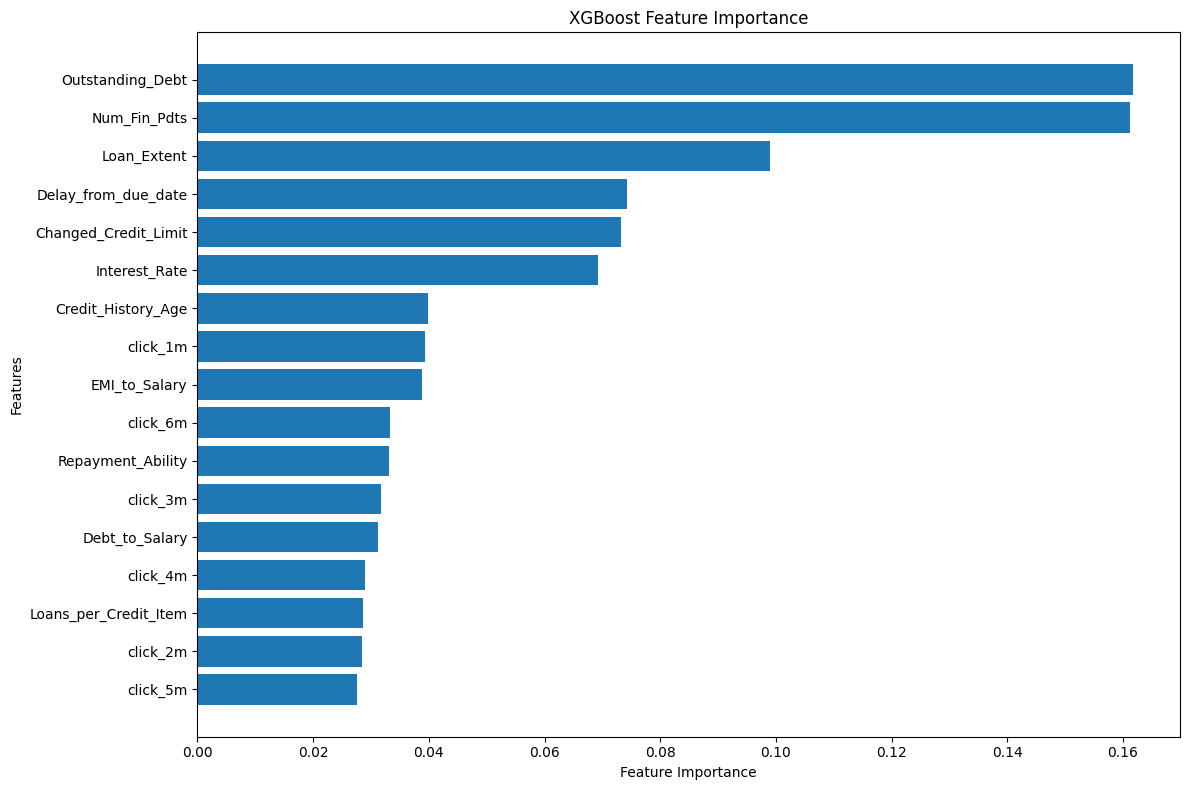

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature names and their importances
importances = best_model.feature_importances_
feature_names = fill_cols

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]  # descending order

# Sort feature names and importances accordingly
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Plot
plt.figure(figsize=(12, 8))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()  # highest importance at the top
plt.tight_layout()
plt.show()


## prepare model artefact to save

In [22]:
model_artefact = {}

model_artefact['model'] = best_model
model_artefact['model_version'] = "credit_model_"+config["model_train_date_str"].replace('-','_')
model_artefact['preprocessing_transformers'] = {}
model_artefact['preprocessing_transformers']['stdscaler'] = transformer_stdscaler
model_artefact['data_dates'] = config
model_artefact['data_stats'] = {}
model_artefact['data_stats']['X_train'] = X_train.shape[0]
model_artefact['data_stats']['X_test'] = X_test.shape[0]
model_artefact['data_stats']['X_oot'] = X_oot.shape[0]
model_artefact['data_stats']['y_train'] = round(y_train.mean(),2)
model_artefact['data_stats']['y_test'] = round(y_test.mean(),2)
model_artefact['data_stats']['y_oot'] = round(y_oot.mean(),2)
model_artefact['results'] = {}
model_artefact['results']['auc_train'] = train_auc_score
model_artefact['results']['auc_test'] = test_auc_score
model_artefact['results']['auc_oot'] = oot_auc_score
model_artefact['results']['gini_train'] = round(2*train_auc_score-1,3)
model_artefact['results']['gini_test'] = round(2*test_auc_score-1,3)
model_artefact['results']['gini_oot'] = round(2*oot_auc_score-1,3)
model_artefact['hp_params'] = random_search.best_params_


pprint.pprint(model_artefact)

{'data_dates': {'model_train_date': datetime.datetime(2024, 9, 1, 0, 0),
                'model_train_date_str': '2024-09-01',
                'oot_end_date': datetime.datetime(2024, 8, 31, 0, 0),
                'oot_period_months': 2,
                'oot_start_date': datetime.datetime(2024, 7, 1, 0, 0),
                'train_test_end_date': datetime.datetime(2024, 6, 30, 0, 0),
                'train_test_period_months': 12,
                'train_test_ratio': 0.8,
                'train_test_start_date': datetime.datetime(2023, 7, 1, 0, 0)},
 'data_stats': {'X_oot': 975,
                'X_test': 563,
                'X_train': 2251,
                'y_oot': np.float64(0.29),
                'y_test': np.float64(0.28),
                'y_train': np.float64(0.28)},
 'hp_params': {'colsample_bytree': 0.8,
               'gamma': 0.1,
               'learning_rate': 0.1,
               'max_depth': 3,
               'min_child_weight': 3,
               'n_estimators': 50,
          

## save artefact to model bank

In [23]:
# create model_bank dir
model_bank_directory = "model_bank/"

if not os.path.exists(model_bank_directory):
    os.makedirs(model_bank_directory)

In [24]:
# Full path to the file
file_path = os.path.join(model_bank_directory, model_artefact['model_version'] + '.pkl')

# Write the model to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(model_artefact, file)

print(f"Model saved to {file_path}")


Model saved to model_bank/credit_model_2024_09_01.pkl


## test load pickle and make model inference

In [25]:
# Load the model from the pickle file
with open(file_path, 'rb') as file:
    loaded_model_artefact = pickle.load(file)

y_pred_proba = loaded_model_artefact['model'].predict_proba(X_oot_processed)[:, 1]
oot_auc_score = roc_auc_score(y_oot, y_pred_proba)
print("OOT AUC score: ", oot_auc_score)

print("Model loaded successfully!")

OOT AUC score:  0.7871599288075262
Model loaded successfully!
